<a href="https://colab.research.google.com/github/denethkavishan/AppReview-RatingProject/blob/main/Finalinterface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision pandas gradio scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

# Load Excel
df = pd.read_excel("/content/drive/MyDrive/my research/final dataset/therapeutic_garden_dataset.xlsx")

# Assuming 'Var50' is the target variable based on the DataFrame structure
target = 'Var50'
X = pd.get_dummies(df.drop(columns=[target]))
y = df[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)

DecisionTreeRegressor()

In [3]:
import os, torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets.folder import default_loader

image_dir = "/content/drive/MyDrive/garden_app/overlays"

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

class GardenDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir)
                      if f.lower().endswith(('.jpg', '.png'))]
        self.transform = transform
        self.loader = default_loader
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = self.loader(self.paths[idx])
        if self.transform: img = self.transform(img)
        return img

dataset = GardenDataset(image_dir, transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [4]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8), nn.ReLU(True),
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4), nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2), nn.ReLU(True),
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf), nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, input): return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False), nn.LeakyReLU(0.2),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False), nn.BatchNorm2d(ndf*2), nn.LeakyReLU(0.2),
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False), nn.BatchNorm2d(ndf*4), nn.LeakyReLU(0.2),
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False), nn.BatchNorm2d(ndf*8), nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d(1), # Add AdaptiveAvgPool2d layer
            nn.Conv2d(ndf*8, 1, 1, 1, 0, bias=False), # Change kernel size to 1
            nn.Sigmoid()
        )
    def forward(self, input): return self.main(input)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netG, netD = Generator().to(device), Discriminator().to(device)
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002)
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002)
criterion = nn.BCELoss()
nz = 100
real_label, fake_label = 1., 0.

for epoch in range(3):  # Adjust to 10+ for real training
    for i, data in enumerate(dataloader):
        b_size = data.size(0)
        real = data.to(device)
        # Create labels for real and fake data
        real_labels = torch.full((b_size,), real_label, dtype=torch.float32, device=device)
        fake_labels = torch.full((b_size,), fake_label, dtype=torch.float32, device=device)

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        netD.zero_grad()
        # Train with all-real batch
        output = netD(real).view(-1)
        errD_real = criterion(output, real_labels)
        errD_real.backward()

        # Train with all-fake batch
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, fake_labels)
        errD_fake.backward()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        output = netD(fake).view(-1)
        errG = criterion(output, real_labels) # Generator wants discriminator to think fakes are real
        errG.backward()
        optimizerG.step()

    print(f"Epoch [{epoch+1}/3] Done")

Epoch [1/3] Done
Epoch [2/3] Done
Epoch [3/3] Done


In [6]:
sample_row = X.sample(1, random_state=42)  # or X.iloc[0]
scaled = scaler.transform(sample_row)
score = dt_model.predict(scaled)[0]


In [7]:
import gradio as gr
import torchvision.utils as vutils
import numpy as np
from PIL import Image

def modify_uploaded_image(uploaded_image):
    # Convert uploaded image to tensor (if needed)
    # → Optionally analyze features or extract data from image
    # → Here, we simulate prediction using Decision Tree + GAN

    # STEP 1: Simulate prediction
    sample_input = pd.DataFrame([X.iloc[0]])  # just use first row features
    sample_scaled = scaler.transform(sample_input)
    predicted_score = dt_model.predict(sample_scaled)[0]

    # STEP 2: Generate garden image with GAN
    with torch.no_grad():
        noise = torch.randn(1, nz, 1, 1, device=device)
        fake = netG(noise).detach().cpu()
        grid = vutils.make_grid(fake, normalize=True)
        img = np.transpose(grid.numpy(), (1, 2, 0))

    suggestion = f"Predicted mental health score: {predicted_score:.2f}. Consider adding shaded seating, soft plants, and water elements."

    return img, suggestion

iface = gr.Interface(
    fn=modify_uploaded_image,
    inputs=gr.Image(type="pil", label="Upload Garden Image"),
    outputs=[
        gr.Image(label="Modified Garden Design"),
        gr.Textbox(label="AI Suggestion")
    ],
    title="AI Garden Modifier for Mental Health"
)

iface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://018332b20f708eaa8d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [8]:
g_losses = []
d_losses = []


In [9]:
g_losses.append(errG.item())
d_losses.append(errD.item())


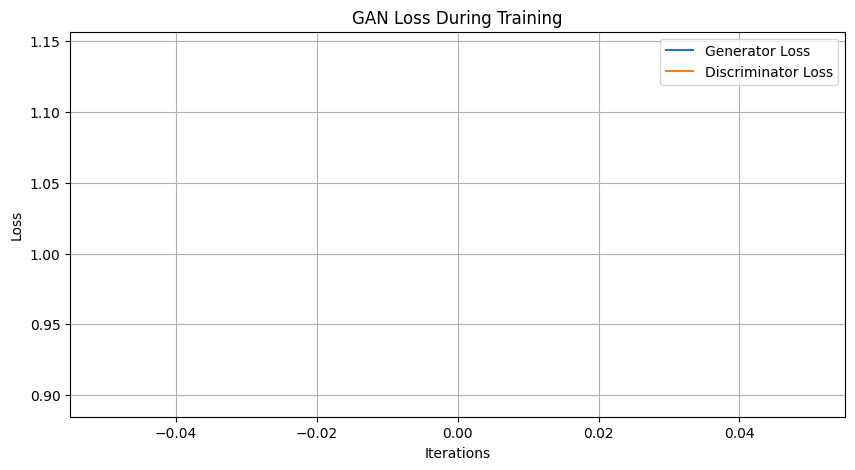

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("GAN Loss During Training")
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
from sklearn.metrics import r2_score, mean_squared_error

y_pred = dt_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Decision Tree R² Score: {r2:.2f}")
print(f"Mean Squared Error: {mse:.2f}")


Decision Tree R² Score: -0.67
Mean Squared Error: 1637.52


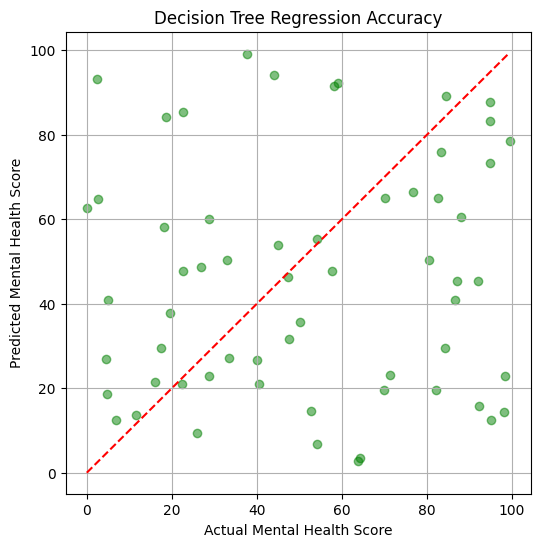

In [12]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='green')
plt.xlabel("Actual Mental Health Score")
plt.ylabel("Predicted Mental Health Score")
plt.title("Decision Tree Regression Accuracy")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Diagonal reference
plt.grid(True)
plt.show()


Decision Tree R² Score: -0.67
Mean Squared Error: 1637.52


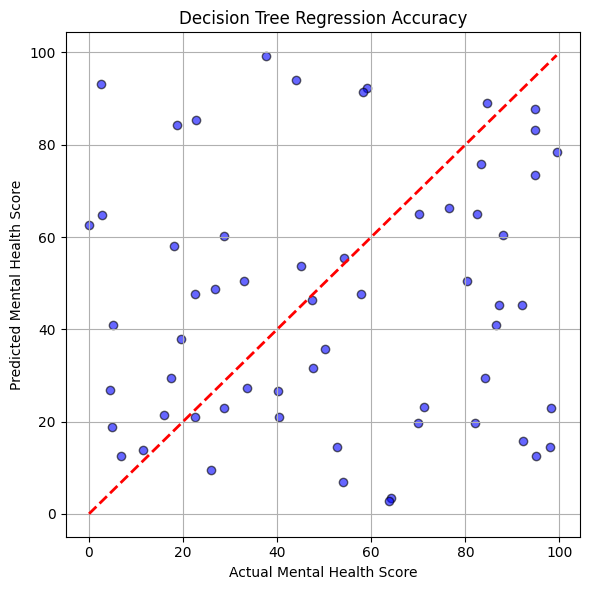

In [13]:
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Predict on test set
y_pred = dt_model.predict(X_test)

# Accuracy metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Decision Tree R² Score: {r2:.2f}")
print(f"Mean Squared Error: {mse:.2f}")

# Plot: Predicted vs Actual
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue', edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("Actual Mental Health Score")
plt.ylabel("Predicted Mental Health Score")
plt.title("Decision Tree Regression Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
g_losses = []
d_losses = []


In [15]:
g_losses.append(errG.item())
d_losses.append(errD.item())


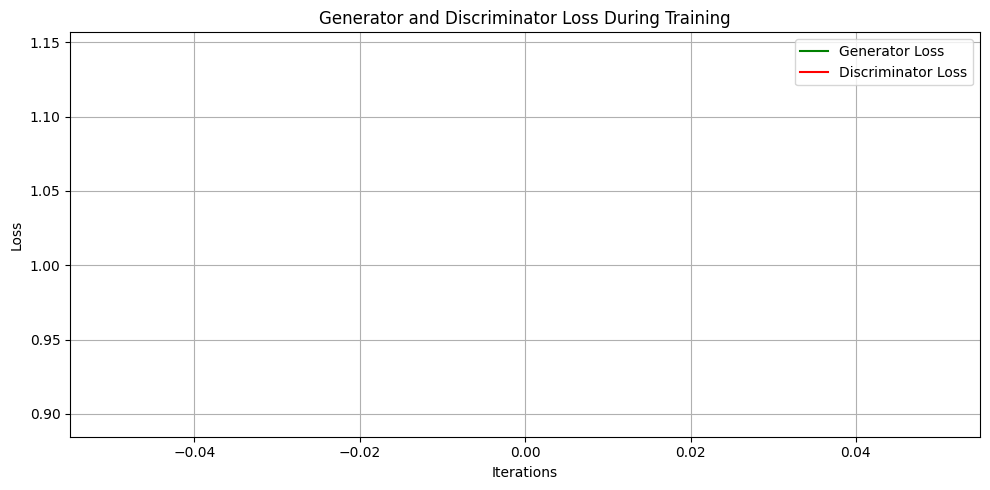

In [16]:
# GAN Loss Plot
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses, label="Generator Loss", color="green")
plt.plot(d_losses, label="Discriminator Loss", color="red")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
def modify_uploaded_image(uploaded_image):
    # Existing code...
    predicted_score = dt_model.predict(sample_scaled)[0]

    # Generate fake image from GAN
    with torch.no_grad():
        noise = torch.randn(1, nz, 1, 1, device=device)
        fake = netG(noise).detach().cpu()
        grid = vutils.make_grid(fake, normalize=True)
        img = np.transpose(grid.numpy(), (1, 2, 0))

    suggestion = f"""Predicted mental health score: {predicted_score:.2f}
Decision Tree R² Accuracy: {r2:.2f}
Suggestion: Consider adding shaded seating, soft plants, and water elements."""

    return img, suggestion


In [18]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Make predictions
y_pred = dt_model.predict(X_test)

# Evaluation metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print results
print(f"Decision Tree R² Score (Accuracy): {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Decision Tree R² Score (Accuracy): -0.67
Mean Absolute Error (MAE): 32.11
Root Mean Squared Error (RMSE): 40.47


In [19]:
from sklearn.metrics import accuracy_score

# Convert continuous target into categories
def to_class(val):
    if val < 3:
        return 0  # Low
    elif val < 7:
        return 1  # Medium
    else:
        return 2  # High

y_test_class = y_test.apply(to_class)
y_pred_class = pd.Series(y_pred).apply(to_class)

acc = accuracy_score(y_test_class, y_pred_class)
print(f"Classification Accuracy Rate: {acc * 100:.2f}%")


Classification Accuracy Rate: 83.33%
